In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (DAILY, rrulewrapper, RRuleLocator)
import matplotlib.ticker as ticker
import math

In [22]:
import numpy as np
import pandas as pd

In [23]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [25]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [27]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [28]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [30]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [31]:
results = session.query(func.Max(Measurement.date))
[maxdate] = [result for result in results]
maxdate

('2017-08-23')

In [32]:
# Set begindate the date 1 year ago from the last data point in the database
begindate = dt.datetime(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
lastyeardata = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= begindate).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame sorted by date
Prcpdf = pd.DataFrame(lastyeardata, columns=['Date', 'prcp'])


#convert string date types to date
Prcpdf['Date'] = pd.to_datetime(Prcpdf['Date'], format='%Y-%m-%d')
Prcpdf

,Date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
...,...,...
2218,2017-08-22,0.50
2219,2017-08-23,0.00
2220,2017-08-23,0.00
2221,2017-08-23,0.08


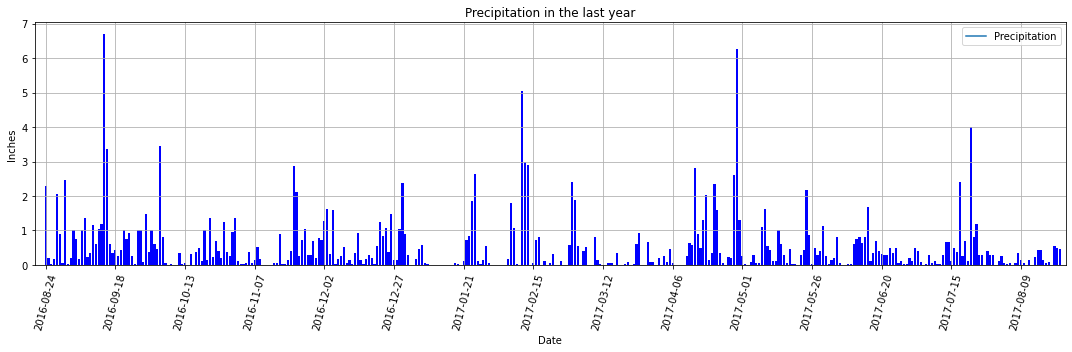

In [33]:
#define for setting xticks
rule = rrulewrapper(DAILY, interval=25)
loc = RRuleLocator(rule)

#set plot figure size
plt.figure(figsize=(15,5))

#plot chart and set/format xticks
plt.bar(Prcpdf['Date'], Prcpdf['prcp'], color='b', align="center")
plt.gca().xaxis.set_major_locator(loc)
plt.xticks(rotation=75)

#set labels
plt.title("Precipitation in the last year")
plt.ylabel("Inches")
plt.xlabel("Date")

#set axes limits
plt.xlim(dt.datetime(2016, 8, 20),  dt.datetime(2017, 8, 25))


#chart properties
plt.grid(True)
plt.plot(Prcpdf['prcp'],label='Precipitation')
plt.legend(loc="upper right")
plt.tight_layout()

#show chart
plt.show()

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Prcpdf['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [35]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).all()
print(len(stations))


9


In [36]:
# What are the most active stations? (i.e. what stations have the most rows)?
mostactivestation = session.query(Measurement.station, func.count(Measurement.id)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.id).desc()).first()

mostactivestation

('USC00519281', 2772)

In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
activestats = session.query(func.Min(Measurement.tobs), func.Max(Measurement.tobs), func.Avg(Measurement.tobs)).\
                        filter(Measurement.station=='USC00519281').\
                        group_by(Measurement.station).all()
activestats
[stats] = [result for result in activestats]
print(f" Lowest Temp recoreded for station USC00519281 is {stats[0]}")
print(f" Highest Temp recoreded for station USC00519281 is {stats[1]}")
print(f" Average Temp recoreded for station USC00519281 is {round(stats[2],2)}")

 Lowest Temp recoreded for station USC00519281 is 54.0
 Highest Temp recoreded for station USC00519281 is 85.0
 Average Temp recoreded for station USC00519281 is 71.66


In [38]:
# Choose the station with the highest number of temperature observations.

lastyeartobs = session.query(Measurement.station, func.Count(Measurement.tobs)).\
                    group_by(Measurement.station).\
                    order_by(func.Count(Measurement.station).desc()).all()
                             
lastyeartobs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.tobs).\
                    filter(Measurement.station=='USC00519281').\
                    filter(Measurement.date >= begindate).\
                    order_by(Measurement.tobs).all()


# creare dataframe for results
tobsdf = pd.DataFrame(tobs)
tobsdf



,tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0
...,...
346,81.0
347,82.0
348,82.0
349,82.0


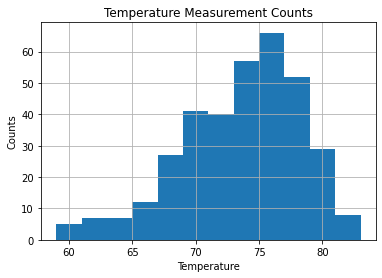

In [40]:
#plot histogram
plt.hist(tobsdf['tobs'], bins=12)




#plot labels
plt.xlabel('Temperature')
plt.ylabel('Counts')
plt.title('Temperature Measurement Counts')


#show plot with grid
plt.grid(True)
plt.show()